In [1]:
import tensorflow as tf

import xml.etree.ElementTree as ET
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset, extract_bboxes, compute_ap
from mrcnn.visualize import display_instances
import matplotlib.pyplot as plt
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
import itertools

! ls -l kangaroo


/home/bruna/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bruna/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bruna/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bruna/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarnin

total 12
drwxrwxr-x 2 bruna bruna 4096 dez 10 16:34 annots
drwxrwxr-x 2 bruna bruna 4096 dez 10 16:34 images
-rw-rw-r-- 1 bruna bruna   75 dez 10 16:34 README.md


Using TensorFlow backend.


In [2]:
# split into train and test set


# class that defines and loads the kangaroo dataset
class KangarooDataset(Dataset):
    # function to extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ET.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height
    
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "kangaroo")
        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        # find all images
        for filename in listdir(images_dir):
            # extract image id
            image_id = filename[:-4]
            # skip bad images
            if image_id in ['00090']:
                continue
            # skip all images after 150 if we are building the train set
            if is_train and int(image_id) >= 150:
                continue
            # skip all images before 150 if we are building the test/val set
            if not is_train and int(image_id) < 150:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)


    # load the masks for an image
    def load_mask(self, image_id):
    # We don’t have masks, but we do have bounding boxes. We can load the bounding boxes for a given photo and return them as masks. 
    # The library will then infer bounding boxes from our “masks” which will be the same size.
    # load the masks for an image

        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('kangaroo'))
        return masks, asarray(class_ids, dtype='int32')
    
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']
    
    


In [3]:
# train set
train_set = KangarooDataset()
train_set.load_dataset('kangaroo', is_train = True)
train_set.prepare()
print('Test: {}'.format(len(train_set.image_ids)))

# test/val set
test_set = KangarooDataset()
test_set.load_dataset('kangaroo', is_train = False)
test_set.prepare()
print('Test: {}'.format(len(test_set.image_ids)))


Test: 131
Test: 32


(333, 400, 3)
(333, 400, 1)


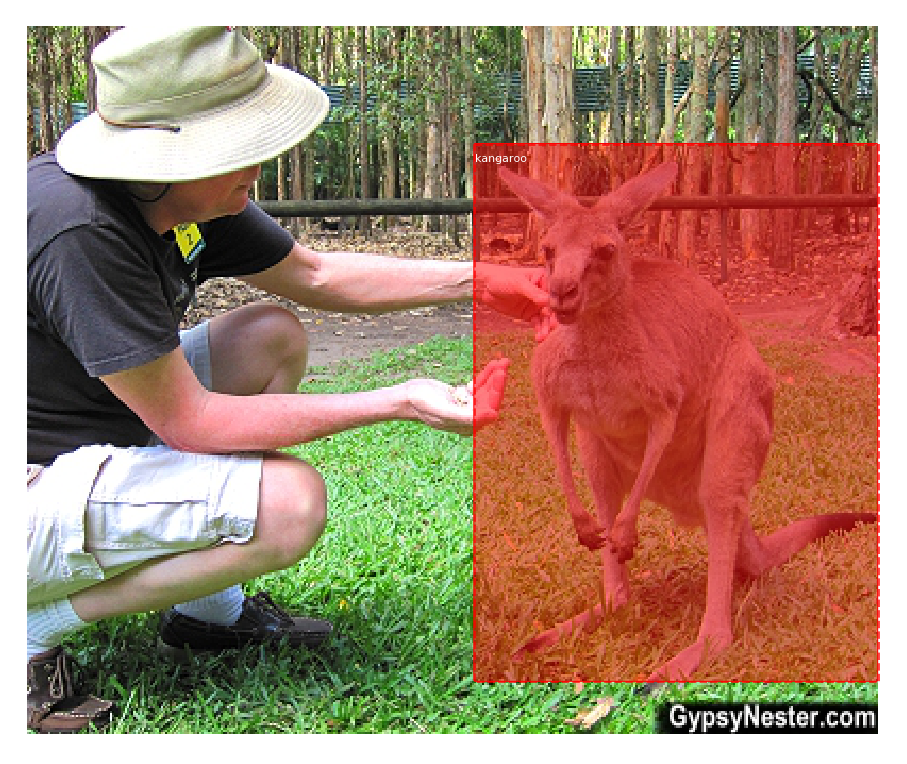

In [4]:
# load an image
image_id = 14
image = train_set.load_image(image_id)
print(image.shape)

# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)

# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)



In [5]:
# define a configuration for the model
class KangarooConfig(Config):
    # Give the configuration a recognizable name
    NAME = "kangaroo_cfg"
    # Number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 131
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
#     # Learning rate
#     LEARNING_RATE=0.006
    
#     # Skip detections with < 90% confidence
#     DETECTION_MIN_CONFIDENCE = 0.9
    
#     # setting Max ground truth instances
#     MAX_GT_INSTANCES=10
#     IMAGEMINDIM = 256
#     IMAGEMAXDIM = 512
#     RPNANCHORSCALES = (4, 8, 16, 32, 64)
#     TRAINROISPERIMAGE = 500 
#     STEPSPEREPOCH = 600 // (IMAGES_PER_GPU * GPU_COUNT)
#     VALIDATIONSTEPS = 70 // (IMAGES_PER_GPU * GPU_COUNT)
#     MEANPIXEL = [0, 0, 0] 
#     LEARNINGRATE = 0.01
#     USEMINIMASK = True
#     MAXGTINSTANCES = 500



In [6]:
# prepare config
config = KangarooConfig()
# config.display()

# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
# load weights (mscoco)
# model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])


Instructions for updating:
Colocations handled automatically by placer.


In [7]:
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./kangaroo_cfg20191210T1835/mask_rcnn_kangaroo_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         

/home/bruna/py36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/bruna/py36/lib/python3.6/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
131/131 [==============================] - 1283s 10s/step - loss: 8.6004 - rpn_class_loss: 0.5017 - rpn_bbox_loss: 4.7165 - mrcnn_class_loss: 0.0802 - mrcnn_bbox_loss: 2.7940 - mrcnn_mask_loss: 0.5082 - val_loss: 6.5528 - val_rpn_class_loss: 0.1226 - val_rpn_bbox_loss: 4.6647 - val_mrcnn_class_loss: 0.1256 - val_mrcnn_bbox_loss: 1.0628 - val_mrcnn_mask_loss: 0.5770
Epoch 2/5
131/131 [==============================] - 1274s 10s/step - loss: 4.7920 - rpn_class_loss: 0.0589 - rpn_bbox_loss: 2.9463 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 1.2520 - mrcnn_mask_loss: 0.4864 - val_loss: 3.2048 - val_rpn_class_loss: 0.0247 - val_rpn_bbox_loss: 3.0817 - val_mrcnn_class_loss: 0.0023 - val_mrcnn_bbox_loss: 0.0752 - val_mrcnn_mask_loss: 0.0209
Epoch 3/5
131/131 [==============================] - 1271s 10s/step - loss: 2.2282 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.8941 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.7166 - mrcnn_mask_loss: 0.5219 - val_loss: 6.0931 - val_rpn_clas

In [13]:
# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "kangaroo_cfg"
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = mean(APs)
    return mAP


In [16]:
# load the train dataset
train_set = KangarooDataset()
train_set.load_dataset('kangaroo', is_train=True)
train_set.prepare()
print('Train: {}'.format(len(train_set.image_ids)))

# load the test dataset
test_set = KangarooDataset()
test_set.load_dataset('kangaroo', is_train=False)
test_set.prepare()
print('Test: {}'.format(len(test_set.image_ids)))

# create config
cfg = PredictionConfig()

# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

# load model weights
model.load_weights('kangaroo_cfg20191210T1835/mask_rcnn_kangaroo_cfg_0005.h5', by_name=True)

# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: {0:.3f}".format(train_mAP))

# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: {0:.3f}".format(test_mAP))

Train: 131
Test: 32
Train mAP: 0.034
Test mAP: 0.032


Train: 131
Test: 32


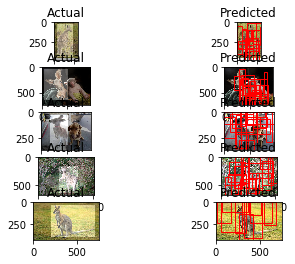

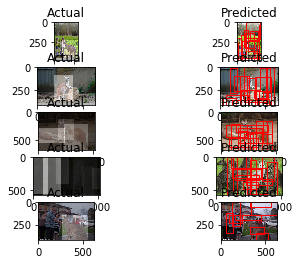

In [23]:
# DETECTAR CANGURUS EM NOVAS IMAGENS
# from matplotlib.pyplot import *

# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
    # load image and mask
    for i in range(n_images):
        # load the image and mask
        image = dataset.load_image(i)
        mask, _ = dataset.load_mask(i)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        # define subplot
        plt.subplot(n_images, 2, i*2+1)
        # plot raw pixel data
        plt.imshow(image)
        plt.title('Actual')
        # plot masks
        for j in range(mask.shape[2]):
            plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
        # get the context for drawing boxes
        plt.subplot(n_images, 2, i*2+2)
        # plot raw pixel data
        plt.imshow(image)
        plt.title('Predicted')
        ax = plt.gca()
        # plot each box
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
    # show the figure
    plt.show()

# load the train dataset
train_set = KangarooDataset()
train_set.load_dataset('kangaroo', is_train=True)
train_set.prepare()
print('Train: {}'.format(len(train_set.image_ids)))

# load the test dataset
test_set = KangarooDataset()
test_set.load_dataset('kangaroo', is_train=False)
test_set.prepare()
print('Test: {}'.format(len(test_set.image_ids)))

# create config
cfg = PredictionConfig()

# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

# load model weights
model_path = 'kangaroo_cfg20191210T1835/mask_rcnn_kangaroo_cfg_0005.h5'
model.load_weights(model_path, by_name=True)

# plot predictions for train dataset
plot_actual_vs_predicted(train_set, model, cfg)
plot_actual_vs_predicted
# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, cfg)